## Assignment A3a: Signals and Noise

### David Courtney 3643806

In [1]:
using DSP, HDF5, LinearAlgebra, Plots, Plots.PlotMeasures, Random, Statistics, WAV

# Code from A1b
function sinewave(t; f=1.0, d=0.0)
    return sin.(2 * pi * f * (t .- d))
end

# Code from A1b
function ERB(f)
    return 24.7 * (4.37 * f / 1000 + 1)
end

# Code from A1b
#function gammatone(t; f=100, n=4, a=1, phi=0)
#    b = 1.019 * ERB(f)
#    return a * t .^ (n - 1) .* exp.(-2 * pi * b * t) .* cos.(2 * pi * f * t .+ phi)
#end

# Professor Lewicki's version of gammatone
function gammatone(t; f=1, phi=0, n=4, a=1, fs=1)
    t <= 0.0 && return 0.0
    # normalize if samp freq is provided
    # and normalizing const is not (ie the default a==1)
    if fs != 1 && a == 1
        a = 1/gammatone_norm(; f, phi, n, fs)
    end
    b = 1.019 * ERB(f)
    return a*t^(n-1) * exp(-2 * pi * b * t) * cos(2 * pi * f *t + phi)
end

# Code from A1b
#function gammatone_norm(f, fs, n=4)
#    duration = 1
#    t = range(0, stop=duration, length=Int(fs * duration))
#    g = [gammatone(ti; f=f, n=n, a=1, phi=0) for ti in t]
#    a = 1 / sqrt(sum(g .^ 2) / length(t))
#    return a
#end

# Professor Lewicki's version of gammatone_norm
function gammatone_norm(; f=1, phi=0, n=4, fs=1)
    t = range(0, 20/f, step=1/fs) # non-zero range
    return norm(gammatone.(t; f, phi, n))
end

# 1a
function plot_sampled_function(g; fs=1, tlim=(0, 2pi), tscale=1, tunits="secs", kwargs...)
    t = range(tlim[1], stop=tlim[2], length=1000)
    sampled_t = range(tlim[1], stop=tlim[2], step=1/fs)
    
    y = g.(t)
    sampled_y = g.(sampled_t)
    
    p = plot(t .* tscale, y, label="Continuous", title="", xlabel="Time ($tunits)", ylabel="", size=(600, 210), bottom_margin=20px, legend=false, kwargs...)
    scatter!(p, sampled_t .* tscale, sampled_y, marker=:circle, markersize=3, line=:stem, label="Samples", color=:red)

    return p
end

# 1b
function cosinewave(t; f=1.0, d=0.0)
    return cos.(2 * pi * f * (t .- d))
end

# 2a
function delta(t; fs=1)
    delta_t = 1 / fs
    return abs(t) <= delta_t/2 ? 1 : 0
end

# 2a
function u(t, start_time=0)
    return t .>= start_time
end

# 2b
function gensignal(t, g; tau=0.025, T=0.1)
    x = zeros(length(t))

    for (i, ti) in enumerate(t)
        if tau <= ti < T + tau
            x[i] = g(ti - tau)
        else
            x[i] = 0
        end
    end
    
    return x
end

# 3a
function energy(x)
    return sum(abs.(x).^2)
end

# 3a
function power(x)
    N = length(x)
    return sum(abs.(x).^2) / N
end

# 3a
function snr(Ps, Pn)
    return 10 * log10(Ps / Pn)
end

# 3b
function noisysignal(t; g, tau, T, sigma)
    if tau <= t <= tau + T
        signal = g(t - tau)
    else
        signal = 0
    end

    noise = sigma * randn()

    return signal + noise
end

# 3c
function snr2sigma(; x, xrange=1:length(x), snr=10)
    signal_power = mean(abs.(x[xrange]).^2)
    snr_linear = 10^(snr / 10)
    noise_power = signal_power / snr_linear
    sigma = sqrt(noise_power)
    return sigma
end

# 3d
function extent(y; theta=0.01)
    threshold = theta * maximum(abs.(y))
    indices = findall(x -> abs(x) > threshold, y)
    return length(indices) > 0 ? (first(indices):last(indices)) : (0:0)
end

# 4
function synthesize_gammatone(f, tau, T, fs, A=1.0)
    t = 0:1/fs:(T-1/fs)
    n = 4
    b = 1.019
    phi = 0
    g = ((t .- tau).^3) .* exp.(-2 .* pi .* b .* (t .- tau)) .* cos.(2 .* pi .* f .* (t .- tau) .+ phi)
    g[t .< tau] .= 0
    return A * g
end

function step_function(t, delay, duration; fs=1)
    return [((ti >= delay) && (ti < delay + duration)) ? 1 : 0 for ti in t]
end

step_function (generic function with 1 method)

In [2]:
default(titlefontsize=12)
plotkw = (tscale = 10^3, tunits="msecs")

(tscale = 1000, tunits = "msecs")

### 1a. Sampled functions


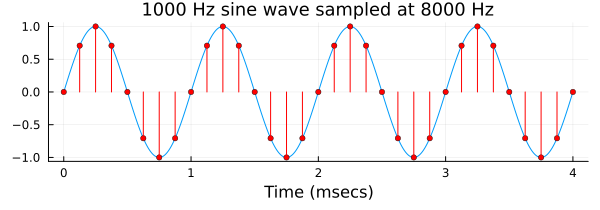

In [3]:
f    = 1000
fs   = 8000
tlim = (0, 0.004)

p = plot_sampled_function(t -> sinewave(t, f=f), fs=fs, tlim=tlim; plotkw...)
title!("$f Hz sine wave sampled at $fs Hz")
display(p)


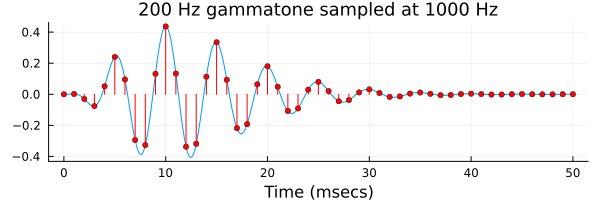

In [4]:
f    = 200
fs   = 1000
g(t) = gammatone(t; f, fs)
tlim = (0, 0.050)

p = plot_sampled_function(g, fs=fs, tlim=tlim; plotkw...)
title!("$f Hz gammatone sampled at $fs Hz")
display(p)

### 1b. The Nyquist frequency and aliasing


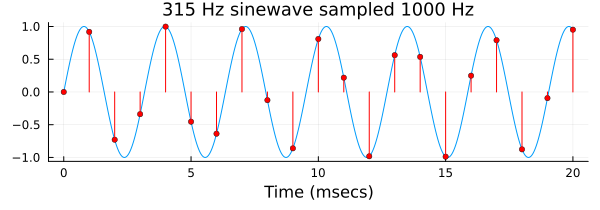

In [5]:
# A sine wave below Nyquist at a frequency that shows a few samples per period which unevenly distributed.
f    = 315
fs   = 1000
tlim = (0, 0.020)

p = plot_sampled_function(t -> sinewave(t, f=f), fs=fs, tlim=tlim; plotkw...)
title!("$f Hz sinewave sampled $fs Hz")


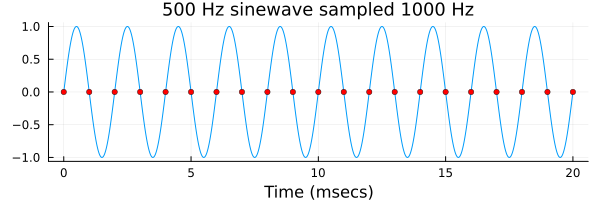

In [6]:
# sine at Nyquist
f    = 500
fs   = 1000
tlim = (0, 0.020)

p = plot_sampled_function(t -> sinewave(t, f=f), fs=fs, tlim=tlim; plotkw...)
title!("$f Hz sinewave sampled $fs Hz")
display(p)


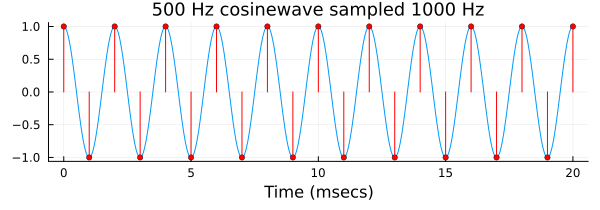

In [7]:
# cosine at Nyquist
f    = 500
fs   = 1000
tlim = (0, 0.020)

p = plot_sampled_function(t -> cosinewave(t, f=f), fs=fs, tlim=tlim; plotkw...)
title!("$f Hz cosinewave sampled $fs Hz")
display(p)


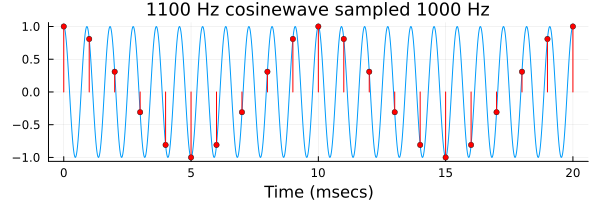

In [8]:
# cosine sampled above Nyquist frequency that clearly shows aliasing

f    = 1100
fs   = 1000
tlim = (0, 0.020)

p = plot_sampled_function(t -> cosinewave(t, f=f), fs=fs, tlim=tlim; plotkw...)
title!("$f Hz cosinewave sampled $fs Hz")
display(p)


### 2. Signals

### 2a. Delta and step functions

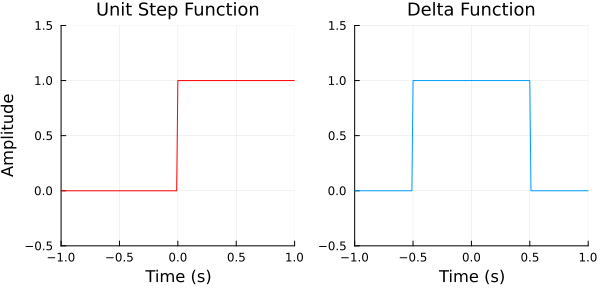

In [9]:
# Parameters
fs = 1
t = -1:0.01:1

# Generate signals
delta_signal = [delta(ti; fs=fs) for ti in t]
step_signal = [u(ti) for ti in t]

# Create the individual plots
p1 = plot(t, step_signal, label="Unit Step Function",
title="Unit Step Function", xlabel="Time (s)", ylabel="Amplitude",
color=:red, xlims=(-1, 1), ylims=(-0.5, 1.5), bottom_margin=20px, legend=false)

p2 = plot(t, delta_signal, label="Delta Function",
title="Delta Function", xlabel="Time (s)", ylabel="",
xlims=(-1, 1), ylims=(-0.5, fs + 0.5), bottom_margin=20px, legend=false)

# Combine the plots side-by-side
plot(p1, p2, layout=(1, 2), size=(600, 300))

### 2b. `gensignal`


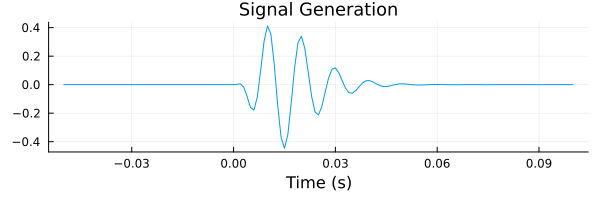

In [10]:
# Define time range for the signal
t = -0.05:0.001:0.1

# Define parameters for the signal generation
a   = 4000000
f   = 100
tau = 0      # Delay of 0s
T   = 2      # Duration of 2s
fs  = 1

# Generate the signal
x = gensignal(t, t -> gammatone(t; f=f, a=a), tau=tau, T=T)

# Plot the signal
plot(t, x, label="Delayed and Limited Duration Signal",
title="Signal Generation",
xlabel="Time (s)",
ylabel="",
size=(600, 200), bottom_margin=20px, legend=false)


### 3. Noise and SNR

### 3a. `energy`, `power`, and `snr`

In [11]:
function energy(x)
    return sum(abs.(x).^2)
end

function power(x)
    N = length(x)
    return sum(abs.(x).^2) / N
end

function snr(Ps, Pn)
    return 10 * log10(Ps / Pn)
end

snr (generic function with 1 method)

### 3b. Noisy signals


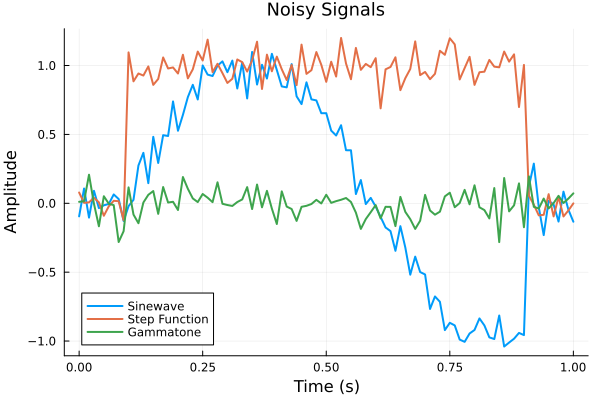

In [12]:
step_function(t) = t >= 0 ? 1 : 0

t     = 0:0.01:1
tau   = 0.1
T     = 0.8
sigma = 0.1

y_sinewave      = [noisysignal(ti; g=sinewave,      tau=tau, T=T, sigma=sigma) for ti in t]
y_step_function = [noisysignal(ti; g=step_function, tau=tau, T=T, sigma=sigma) for ti in t]
y_gammatone     = [noisysignal(ti; g=gammatone,     tau=tau, T=T, sigma=sigma) for ti in t]

p = plot(t, y_sinewave, label="Sinewave", title="Noisy Signals", xlabel="Time (s)", ylabel="Amplitude", lw=2)
plot!(t, y_step_function, label="Step Function", lw=2)
plot!(t, y_gammatone, label="Gammatone", lw=2)

display(p)


### 3c. Noise level specified by SNR

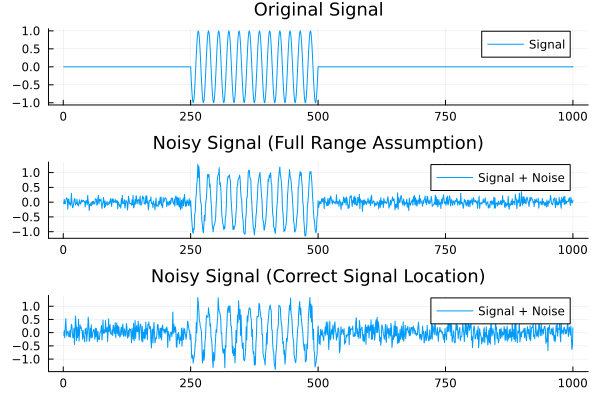

In [13]:
N             = 1000
x             = zeros(N)
signal_length = div(N, 4)
signal_start  = div(N, 4)
signal_end    = signal_start + signal_length
t             = 1:N

x[signal_start:signal_end] .= sin.(2 * pi * 0.05 * t[signal_start:signal_end])

sigma_full    = snr2sigma(x=x, snr=10)
sigma_partial = snr2sigma(x=x, xrange=signal_start:signal_end, snr=10)
noise_full    = sigma_full * randn(N)
noise_partial = sigma_partial * randn(N)
y_full        = x + noise_full
y_partial     = x + noise_partial

p1 = plot(t, x, title="Original Signal", label="Signal")
p2 = plot(t, y_full, title="Noisy Signal (Full Range Assumption)", label="Signal + Noise")
p3 = plot(t, y_partial, title="Noisy Signal (Correct Signal Location)", label="Signal + Noise")
plot(p1, p2, p3, layout=(3, 1), legend=:topright)


### 3d. Estimating SNR

In [14]:
# Example usage of the extent function
y_example = [0.01, 0.02, 0.5, 0.7, 0.4, 0.02, 0.01]
extent_range = extent(y_example; theta=0.05)
println("Extent range for the example: ", extent_range)

# Synthesize a signal with known SNR
N = 1000
signal = sin.(2 * pi * 0.05 * (1:N))
noise_sigma = snr2sigma(x=signal, snr=10)
noise = noise_sigma * randn(N)
noisy_signal = signal + noise

# Use the extent function to find the signal range
signal_extent = extent(noisy_signal; theta=0.01)

# Estimate SNR within the extent
signal_power = mean(abs.(noisy_signal[signal_extent]).^2)
noise_power = mean(abs.(noisy_signal[setdiff(1:N, signal_extent)]).^2)
estimated_snr = 10 * log10(signal_power / noise_power)

println("Estimated SNR: ", estimated_snr, " dB")


Extent range for the example: 3:5
Estimated SNR: NaN dB


### 4. Grand synthesis


In [15]:
# Parameters for the synthesis
T    = 15.0  # Total time in seconds
fs   = 44100  # Sampling frequency in Hz
fmin = 200  # Minimum frequency in Hz
fmax = 8000  # Maximum frequency in Hz
num_signals = 10  # Number of gammatone signals to synthesize
noise_level = 0.05  # Standard deviation of Gaussian noise
A = 1.0  # Amplitude of each gammatone (constant in this case)

# Synthesize the waveform
Random.seed!(123)  # For reproducibility
waveform = zeros(Int(round(T * fs)))  # Total number of samples
for _ = 1:num_signals
    tau_i = rand() * T
    f_i = rand() * (fmax - fmin) + fmin
    waveform += synthesize_gammatone(f_i, tau_i, T, fs, A)
end

# Normalize the waveform to prevent clipping
waveform /= maximum(abs.(waveform))

# Add Gaussian noise
waveform += noise_level * randn(length(waveform))

# Write the waveform to a WAV file
WAV.wavwrite(waveform, "synthesized_gammatone.wav", Fs=fs)

# The file sounds like static and high pitched tones.


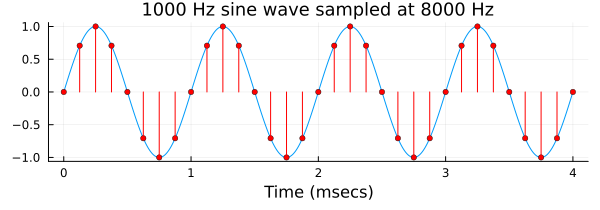

In [16]:
# Quiz Question 1
f    = 1000
fs   = 8000
tlim = (0, 0.004)

p = plot_sampled_function(t -> sinewave(t, f=f), fs=fs, tlim=tlim; plotkw...)
title!("$f Hz sine wave sampled at $fs Hz")
display(p)

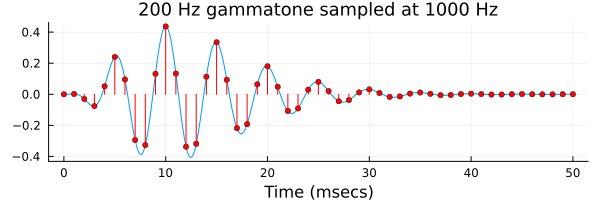

In [17]:
# Quiz Question 2
f    = 200
fs   = 1000
g(t) = gammatone(t; f, fs)
tlim = (0, 0.050)

p = plot_sampled_function(g, fs=fs, tlim=tlim; plotkw...)
title!("$f Hz gammatone sampled at $fs Hz")
display(p)

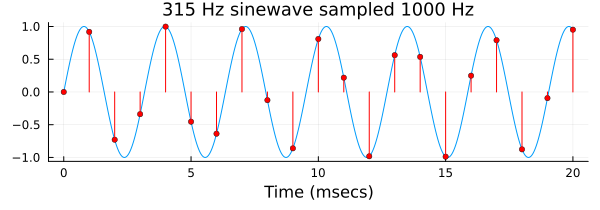

In [18]:
# Quiz Question 3
f    = 315
fs   = 1000
tlim = (0, 0.020)

p = plot_sampled_function(t -> sinewave(t, f=f), fs=fs, tlim=tlim; plotkw...)
title!("$f Hz sinewave sampled $fs Hz")

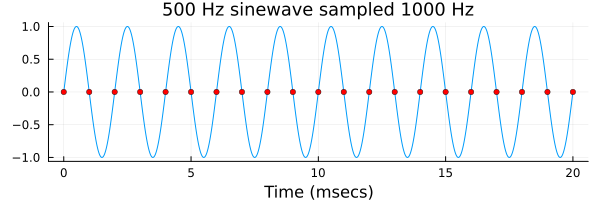

In [19]:
# Quiz Question 4
f    = 500
fs   = 1000
tlim = (0, 0.020)

p = plot_sampled_function(t -> sinewave(t, f=f), fs=fs, tlim=tlim; plotkw...)
title!("$f Hz sinewave sampled $fs Hz")
display(p)

In [20]:
# Quiz Question 5

# Constants
f  = 1100  # frequency of the cosine wave in Hz
fs = 1000  # sampling frequency in Hz

# Calculate the apparent frequency
n          = floor(f / fs)    # Number of full sampling rates that fit into the frequency
f_apparent = abs(f - n * fs)  # Apparent frequency after aliasing

println("The apparent frequency of a 1100 Hz cosine wave sampled at 1000 Hz is $(f_apparent) Hz")


The apparent frequency of a 1100 Hz cosine wave sampled at 1000 Hz is 100.0 Hz


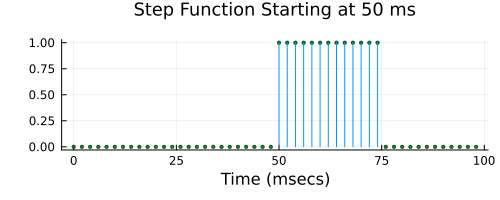

In [21]:
# Quiz Question 6

# Sampling frequency and corresponding sample interval
fs         = 500    # in Hz
dt         = 1/fs   # in seconds
duration   = 0.025  # duration of the step in seconds (25 ms)
start_time = 0.05   # start time of the step in seconds (50 ms)

# Create a time array from 0 to 100 ms (0.1 seconds) with steps of dt
t = 0:dt:0.1-dt  # Adjust for Julia indexing

step_signal = u.(t, start_time) .- u.(t, start_time + duration)

plot(t .* 1000, step_signal, title="Step Function Starting at 50 ms",
     xlabel="Time (msecs)", ylabel="", legend=false,
     line=:stem, marker=:circle, markercolor=:green, markersize=2,
     size=(500, 200), left_margin=20px, top_margin=20px, bottom_margin=20px)


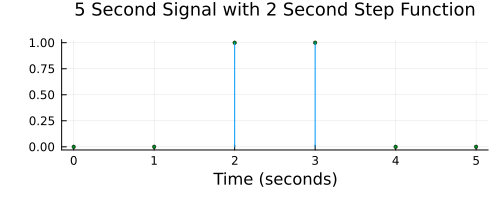

In [22]:
# Quiz Question 7

# Parameters for this scenario
fs         = 1     # new sampling frequency in Hz
dt         = 1/fs  # new sample interval in seconds
duration   = 2     # new duration of the step in seconds
start_time = 2     # new start time of the step in seconds
total_time = 6     # total duration of the signal in seconds

# Create a new time array from 1 to 5 seconds with steps of dt
t = 0:dt:total_time-dt  # Adjust for Julia indexing

step_signal = u.(t, start_time) .- u.(t, start_time + duration)

plot(t, step_signal, title="5 Second Signal with 2 Second Step Function",
     xlabel="Time (seconds)", ylabel="", legend=false,
     line=:stem, marker=:circle, markercolor=:green, markersize=2,
     size=(500, 200), left_margin=20px, top_margin=20px, bottom_margin=20px)


In [23]:
# Quiz Question 8

# Define the time array based on the sampling frequency and duration
fs = 100            # Sampling frequency in Hz
f  = 1.0            # Frequency of the sine wave in Hz
T  = 1              # Duration in seconds
t  = 0:1/fs:T-1/fs  # Time array from 0 to just under one second in steps of 1/fs

# Generate the sine wave samples using the sinewave function
x = sinewave(t, f=f)  # Using default frequency of 1.0 Hz and default delay of 0.0

E = energy(x)
println("The energy of the 1 Hz sine wave is approximately $E")


The energy of the 1 Hz sine wave is approximately 50.0


In [24]:
# Quiz Question 9

# Define the time array based on the sampling frequency and duration
fs = 100            # Sampling frequency in Hz
f  = 1.0            # Frequency of the sine wave in Hz
T  = 1              # Duration in seconds

t = range(0, stop=1, length=fs)

# Generate the sine wave samples using the sinewave function
x = sinewave(t, f=f)  # Using default frequency of 1.0 Hz and default delay of 0.0

P = power(x)
println("The power of the sine wave is: ", P)


The power of the sine wave is: 0.495


In [25]:
# Quiz Question 10
f       = 100    # frequency in Hz
fs      = 1000   # sampling rate in Hz
t_start = 0.005  # start time in s
t_end   = 0.040  # end time in s

t           = range(t_start, stop=t_end, step=1/fs)
signal      = gammatone.(t; f=f, fs=fs)
gpower      = mean(signal .^ 2)

println("The power of the normalized gammatone signal is approximately ", round(gpower, digits=4))

The power of the normalized gammatone signal is approximately 0.0276


In [26]:
# Quiz Question 11

# Given signal and noise power values
P_signal    = 20.0
P_noise     = 1.0
SNR_dB      = snr(P_signal, P_noise)
rounded_SNR = round(SNR_dB, digits=5)

println("The SNR is approximately $rounded_SNR dB")


The SNR is approximately 13.0103 dB


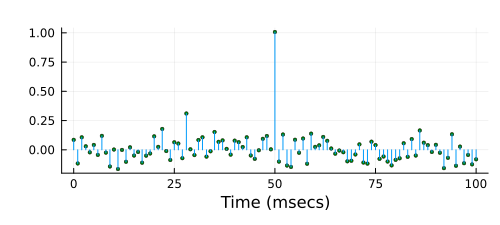

In [27]:
# Quiz Question 12

# Define parameters
fs    = 1000  # Sampling rate in Hz
T     = 0.1   # Total time in seconds (100 ms)
delay = 0.05  # Delay for the delta function in seconds
sigma = 0.1   # Standard deviation of noise

# Generate time vector
t = range(0, stop=T, step=1/fs)

# Generate delta function using provided logic
delta_signal = zeros(length(t))
delta_index  = findfirst(≥(delay), t)  # Find the index for the delay time
delta_signal[delta_index] = 1          # Set the delta peak

# Generate Gaussian noise
noise = sigma * randn(length(t))

# Combine the delta signal and noise
noisy_signal = delta_signal .+ noise

x_ticks = t * fs

plot(x_ticks, noisy_signal, title="", xlabel="Time (msecs)", ylabel="", legend=false,
line=:stem, marker=:circle, markercolor=:green, markersize=2,
size=(500, 225), left_margin=20px, top_margin=20px, bottom_margin=20px)


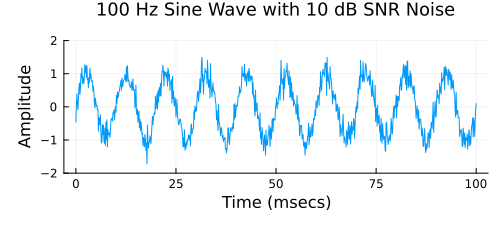

In [28]:
# Quiz Question 13

# Parameters
fs  = 8000   # Sampling rate in Hz
f   = 100    # Frequency of the sine wave in Hz
T   = 0.1    # Total duration in seconds
SNR = 10     # Desired SNR in dB

# Generate time vector
t = range(0, stop=T, step=1/fs)

# Generate the sine wave
sine_signal = sinewave(t, f=f)

# Calculate the power of the sine wave (since it's a full cycle, assume perfect RMS value for sine)
signal_power = mean(sine_signal .^ 2)

# Convert SNR from dB to linear scale and calculate noise power
snr_linear = 10^(SNR / 10)
noise_power = signal_power / snr_linear

# Calculate standard deviation of the noise
noise_sigma = sqrt(noise_power)

# Generate Gaussian noise
noise = noise_sigma * randn(length(t))

# Combine signal and noise
noisy_signal = sine_signal + noise

x_ticks = t * 1000

plot(x_ticks, noisy_signal, title="100 Hz Sine Wave with 10 dB SNR Noise", xlabel="Time (msecs)", ylabel="Amplitude", legend=false,
size=(500, 225), left_margin=20px, top_margin=20px, bottom_margin=20px,
yticks=[-2, -1, 0, 1, 2], ylim=(-2.0, 2.0))


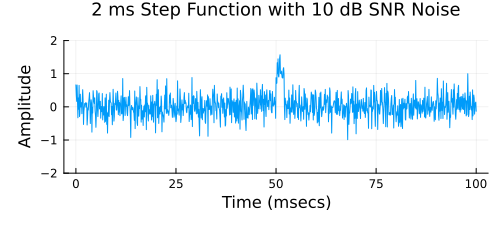

In [29]:
# Quiz Question 14

# Parameters
fs       = 10000  # Assuming sampling rate in Hz if not specified
T        = 0.1    # Total duration in seconds (100 ms)
delay    = 0.05   # Start time of the step in seconds
duration = 0.002  # Duration of the step in seconds
SNR_dB   = 10     # Desired SNR in dB

# Generate time vector
t = range(0, stop=T, step=1/fs)

# Generate step function
signal = step_function(t, delay, duration, fs=fs)

# Calculate signal power within the known signal location for accurate SNR calculation
signal_indices = (t .≥ delay) .& (t .< delay + duration)
signal_power   = mean(signal[signal_indices] .^ 2)

# Convert SNR from dB to linear scale for noise power
snr_linear  = 10^(SNR_dB / 10)
noise_power = signal_power / snr_linear

# Calculate standard deviation of the noise
noise_sigma = sqrt(noise_power)

# Generate Gaussian noise
noise = noise_sigma * randn(length(t))

# Combine signal and noise
noisy_signal = signal + noise

x_ticks = t * 1000

plot(x_ticks, noisy_signal, title="2 ms Step Function with 10 dB SNR Noise",
xlabel="Time (msecs)", ylabel="Amplitude", legend=false,
size=(500, 225), left_margin=20px, top_margin=20px, bottom_margin=20px,
yticks=[-2, -1, 0, 1, 2], ylim=(-2.0, 2.0))


In [30]:
# Quiz Question 15
file_path    = "A3a-testdata-1.h5"
y            = h5read(file_path, "testdata/y")

mean_value   = mean(y)
std_dev      = std(y)
threshold    = mean_value + std_dev
signal_power = mean(y[y .> threshold] .^ 2)
noise_power  = mean(y[y .<= threshold] .^ 2)
SNR          = snr(signal_power, noise_power)

println("Estimated SNR of the pulse: $(round(SNR, digits=4)) dB")

Estimated SNR of the pulse: 11.2561 dB
